The code below reads the data from a MySQL database and stores it in a pandas dataframe.  

Install pymysql to run the code:

```pip install pymysql```

In [ ]:
import os
import pymysql
import pandas as pd

host = os.environ.get("MYSQL_DB_HOST")
user = os.environ.get("MYSQL_DB_USER")
password = os.environ.get("MYSQL_DB_PW")
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

In [3]:
df.shape

(26229, 13)

In [4]:
df['updated_at'].min()

Timestamp('2022-11-02 14:06:48')

In [5]:
df['occupancy_status'].value_counts()

MANY_SEATS_AVAILABLE    15016
FEW_SEATS_AVAILABLE      6887
FULL                     2780
Name: occupancy_status, dtype: int64


The code below saves the data as a csv file to the local directory as a backup.

In [ ]:
df.to_csv('mbta_11.2.22.csv')

<h1>Determining the average time it takes for a bus to complete the route</h1>

In [1]:
import pandas as pd

df = pd.read_csv("mbta_11.2.22.csv", parse_dates=['updated_at'])

In [2]:
df.tail(10)

,record_num,route_number,id,bearing,current_status,current_stop_sequence,direction_id,label,latitude,longitude,occupancy_status,speed,updated_at,group_diff
26219,26135,1,y1895,159,IN_TRANSIT_TO,11.0,1,1895,42.350034,-71.089155,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26220,26144,1,y1895,300,IN_TRANSIT_TO,11.0,1,1895,42.349628,-71.089029,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26221,26153,1,y1895,0,IN_TRANSIT_TO,11.0,1,1895,42.349613,-71.089034,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26222,26162,1,y1895,0,IN_TRANSIT_TO,11.0,1,1895,42.349606,-71.089024,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26223,26171,1,y1895,0,IN_TRANSIT_TO,11.0,1,1895,42.349606,-71.089024,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26224,26180,1,y1895,0,IN_TRANSIT_TO,11.0,1,1895,42.349606,-71.089024,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:03:00,5
26225,26190,1,y1895,0,IN_TRANSIT_TO,11.0,1,1895,42.349601,-71.089013,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:04:00,5
26226,26200,1,y1895,172,IN_TRANSIT_TO,12.0,1,1895,42.349119,-71.088786,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:04:00,5
26227,26210,1,y1895,161,IN_TRANSIT_TO,12.0,1,1895,42.348942,-71.088673,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:04:00,5
26228,26220,1,y1895,170,IN_TRANSIT_TO,12.0,1,1895,42.348353,-71.088514,MANY_SEATS_AVAILABLE,NaN,2022-11-02 23:04:00,5


In [4]:
# Timeframe duration for recording MBTA bus operations
x = df['updated_at'].max() - df['updated_at'].min()
x

Timedelta('0 days 08:58:00')

In [3]:
# Number of records per bus
df['label'].value_counts()

1864    3011
1852    2976
1794    2962
1895    2941
1865    2874
1893    2757
1776    2682
1789    2395
1863    1549
1812    1031
1855     907
1774     144
Name: label, dtype: int64

In [5]:
# Grouping records by bus and lap sequence(represented by the 'group_diff' column)
agg_df = df.groupby(['id', 'current_stop_sequence', 'direction_id', 'group_diff'])\
            .agg({'latitude': ['mean'],'longitude': ['mean'], 'updated_at':['min']})
agg_df

latitude  longitude  \
                                                          mean       mean   
id    current_stop_sequence direction_id group_diff                         
y1774 1.0                   0            0           42.330070 -71.083588   
                            1            0           42.329931 -71.083653   
y1776 1.0                   0            0           42.373122 -71.117827   
                                         1           42.373108 -71.117723   
                                         2           42.371733 -71.116650   
...                                                        ...        ...   
y1895 24.0                  1            0           42.330345 -71.083920   
                                         1           42.330294 -71.084000   
                                         2           42.330456 -71.083620   
                                         3           42.330433 -71.083806   
                                         4           42.330366 -71.083955   

                                                             updated_at  
                                                                    min  
id    current_stop_sequence direction_id group_diff                      
y1774 1.0                   0            0          2022-11-02 22:40:00  
                            1            0          2022-11-02 22:49:00  
y1776 1.0                   0            0          2022-11-02 14:53:00  
                                         1          2022-11-02 16:15:00  
                                         2          2022-11-02 17:04:00  
...                                                                 ...  
y1895 24.0                  1            0          2022-11-02 14:51:00  
                                         1          2022-11-02 16:26:00  
                                         2          2022-11-02 17:55:00  
                                         3          2022-11-02 20:25:00  
                                         4          2022-11-02 22:15:00  

[2162 rows x 3 columns]

In [6]:
agg_df.reset_index(inplace=True)
agg_df

,id,current_stop_sequence,direction_id,group_diff,latitude,longitude,updated_at
,,,,,mean,mean,min
0,y1774,1.0,0,0,42.330070,-71.083588,2022-11-02 22:40:00
1,y1774,1.0,1,0,42.329931,-71.083653,2022-11-02 22:49:00
2,y1776,1.0,0,0,42.373122,-71.117827,2022-11-02 14:53:00
3,y1776,1.0,0,1,42.373108,-71.117723,2022-11-02 16:15:00
4,y1776,1.0,0,2,42.371733,-71.116650,2022-11-02 17:04:00
...,...,...,...,...,...,...,...
2157,y1895,24.0,1,0,42.330345,-71.083920,2022-11-02 14:51:00
2158,y1895,24.0,1,1,42.330294,-71.084000,2022-11-02 16:26:00
2159,y1895,24.0,1,2,42.330456,-71.083620,2022-11-02 17:55:00


In [8]:
# Flattening the dataframe so that there is only one index
agg_df.columns = agg_df.columns.get_level_values(0)
agg_df

,id,current_stop_sequence,direction_id,group_diff,latitude,longitude,updated_at
0,y1774,1.0,0,0,42.330070,-71.083588,2022-11-02 22:40:00
1,y1774,1.0,1,0,42.329931,-71.083653,2022-11-02 22:49:00
2,y1776,1.0,0,0,42.373122,-71.117827,2022-11-02 14:53:00
3,y1776,1.0,0,1,42.373108,-71.117723,2022-11-02 16:15:00
4,y1776,1.0,0,2,42.371733,-71.116650,2022-11-02 17:04:00
...,...,...,...,...,...,...,...
2157,y1895,24.0,1,0,42.330345,-71.083920,2022-11-02 14:51:00
2158,y1895,24.0,1,1,42.330294,-71.084000,2022-11-02 16:26:00
2159,y1895,24.0,1,2,42.330456,-71.083620,2022-11-02 17:55:00
2160,y1895,24.0,1,3,42.330433,-71.083806,2022-11-02 20:25:00


In [9]:
agg_df['group_diff'].value_counts()

1    500
2    420
0    403
3    351
4    305
5    182
6      1
Name: group_diff, dtype: int64

In [10]:
# Selecting the first full lap to compare all busses against eachother
gp_df = agg_df[agg_df['group_diff']==1]
gp_df

,id,current_stop_sequence,direction_id,group_diff,latitude,longitude,updated_at
3,y1776,1.0,0,1,42.373108,-71.117723,2022-11-02 16:15:00
9,y1776,1.0,1,1,42.329861,-71.084035,2022-11-02 15:30:00
16,y1776,2.0,0,1,42.351974,-71.100820,2022-11-02 15:40:00
21,y1776,2.0,1,1,42.366170,-71.112997,2022-11-02 14:57:00
27,y1776,3.0,0,1,42.332391,-71.081358,2022-11-02 15:41:00
...,...,...,...,...,...,...,...
2140,y1895,22.0,1,1,42.332382,-71.081302,2022-11-02 16:24:00
2144,y1895,23.0,0,1,42.371779,-71.115003,2022-11-02 15:39:00
2149,y1895,23.0,1,1,42.330810,-71.083113,2022-11-02 16:25:00
2153,y1895,24.0,0,1,42.372696,-71.116263,2022-11-02 15:40:00


In [11]:
# Archiving the summarized dataframe
gp_df.to_csv('agg_df_11.2.22.csv', index=False)

In [12]:
# First creating a dataframe that contains the finish times for the first full lap
max_df = gp_df.groupby(['id']).agg({'updated_at': ['max']})
max_df.reset_index(inplace=True)
max_df.columns = max_df.columns.get_level_values(0)
max_df = max_df.rename(columns = {'updated_at': 'max_time'})

# Building another dataframe that contains the start times for the first full lap
min_df = gp_df.groupby(['id']).agg({'updated_at': ['min']})
min_df.reset_index(inplace=True)
min_df.columns = min_df.columns.get_level_values(0)
min_df = min_df.rename(columns = {'updated_at': 'min_time'})

# Joining the two dataframes and taking the difference between the start and finish times
duration_df = pd.merge(max_df, min_df, how='inner')
duration_df['duration'] = duration_df['max_time'] - duration_df['min_time']
duration_df

,id,max_time,min_time,duration
0,y1776,2022-11-02 16:15:00,2022-11-02 14:57:00,0 days 01:18:00
1,y1789,2022-11-02 16:50:00,2022-11-02 15:24:00,0 days 01:26:00
2,y1794,2022-11-02 16:14:00,2022-11-02 14:48:00,0 days 01:26:00
3,y1812,2022-11-02 23:04:00,2022-11-02 19:15:00,0 days 03:49:00
4,y1852,2022-11-02 16:51:00,2022-11-02 15:29:00,0 days 01:22:00
5,y1855,2022-11-02 23:03:00,2022-11-02 21:40:00,0 days 01:23:00
6,y1863,2022-11-02 21:31:00,2022-11-02 15:23:00,0 days 06:08:00
7,y1864,2022-11-02 17:10:00,2022-11-02 15:42:00,0 days 01:28:00
8,y1865,2022-11-02 17:16:00,2022-11-02 15:55:00,0 days 01:21:00
9,y1893,2022-11-02 16:29:00,2022-11-02 14:51:00,0 days 01:38:00


### When including all busses, it takes an average of 2 hours and 3 minutes to complete the route.

In [13]:
duration_df['duration'].mean()

Timedelta('0 days 02:03:32.727272727')

### For busses that were fully operational, it took an average of 1 hour and 24 minutes to complete the route.

In [14]:
# Excluding busses 1812 and 1863 which were not fully operational
trimmed_df = duration_df[~duration_df['id'].isin(['y1812','y1863'])]
trimmed_df['duration'].mean()

Timedelta('0 days 01:24:40')

### Converting duration to minutes and then plotting the results

In [15]:
import numpy as np
import datetime as dt

duration_df['minutes'] = duration_df['duration'].dt.total_seconds()/60
duration_df

,id,max_time,min_time,duration,minutes
0,y1776,2022-11-02 16:15:00,2022-11-02 14:57:00,0 days 01:18:00,78.0
1,y1789,2022-11-02 16:50:00,2022-11-02 15:24:00,0 days 01:26:00,86.0
2,y1794,2022-11-02 16:14:00,2022-11-02 14:48:00,0 days 01:26:00,86.0
3,y1812,2022-11-02 23:04:00,2022-11-02 19:15:00,0 days 03:49:00,229.0
4,y1852,2022-11-02 16:51:00,2022-11-02 15:29:00,0 days 01:22:00,82.0
5,y1855,2022-11-02 23:03:00,2022-11-02 21:40:00,0 days 01:23:00,83.0
6,y1863,2022-11-02 21:31:00,2022-11-02 15:23:00,0 days 06:08:00,368.0
7,y1864,2022-11-02 17:10:00,2022-11-02 15:42:00,0 days 01:28:00,88.0
8,y1865,2022-11-02 17:16:00,2022-11-02 15:55:00,0 days 01:21:00,81.0
9,y1893,2022-11-02 16:29:00,2022-11-02 14:51:00,0 days 01:38:00,98.0


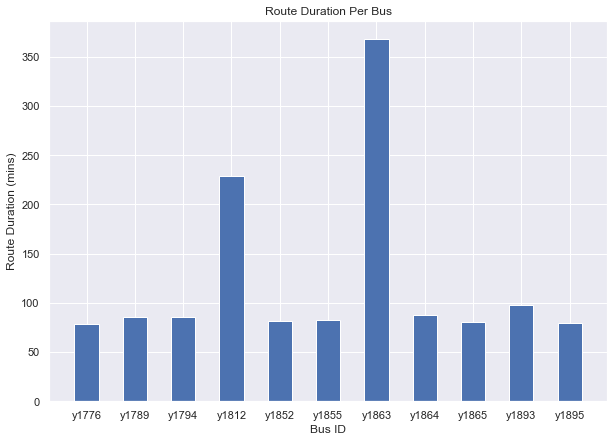

In [22]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot style

plt.bar(duration_df['id'], duration_df['minutes'], width = 0.5)
plt.xlabel("Bus ID")
plt.ylabel("Route Duration (mins)")
plt.title("Route Duration Per Bus")
plt.rcParams["figure.figsize"] = (10,7)
plt.show()